### Malaria Dataset CNN

This is the code for the Malaria dataset described in the report.

In [24]:
# modules
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from collections import Counter
import cv2
from concurrent import futures
import threading
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras import losses
import datetime
import random

## Exploration of the dataset

In [3]:
# list of pathnames of the dataset of infected and healthy cell images
infected_files = glob.glob('./cell_images/Parasitized/*.png')
healthy_files = glob.glob('./cell_images/Uninfected/*.png')
len(infected_files),len(healthy_files)

(13779, 13779)

In [4]:
# create a dataframe using pandas
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': 13779*['Infected'] + 13779*['Healthy']
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head(5)

,filename,label
0,./cell_images/Parasitized\C130P91ThinF_IMG_201...,Infected
1,./cell_images/Parasitized\C188P149ThinF_IMG_20...,Infected
2,./cell_images/Uninfected\C173P134NThinF_IMG_20...,Healthy
3,./cell_images/Uninfected\C78P39ThinF_IMG_20150...,Healthy
4,./cell_images/Uninfected\C107P68ThinF_IMG_2015...,Healthy


In [5]:
# figure out the sizes of the images (minimum, maximum, average, median)

def get_image_size_parallel(number, image):
    if number%5000 == 0:
        print('Working on image number:', number)
    return cv2.imread(image).shape

ex = futures.ThreadPoolExecutor(max_workers=None)

cell_files = files_df['filename'].values
cell_labels = files_df['label'].values

cell_files_number = [(number, image) for number, image in enumerate(cell_files)] 

# save the size of the images in the list image_size through parallel threading
image_sizes = list(ex.map(get_image_size_parallel, [data[0] for data in cell_files_number],
        [data[1] for data in cell_files_number]))

# calculate minimum, maximum, average, median
print('Minimum:', np.min(image_sizes, axis=0))
print('Maximum:', np.max(image_sizes, axis=0))
print('Average:', np.mean(image_sizes, axis=0))
print('Median:', np.median(image_sizes, axis=0))

Working on image number: 0
Working on image number: 5000
Working on image number: 10000
Working on image number: 15000
Working on image number: 20000
Working on image number: 25000
Minimum: [40 46  3]
Maximum: [385 394   3]
Average: [132.98345308 132.48715437   3.        ]
Median: [130. 130.   3.]


## Prepare the data for training

In [6]:
# change the size of the image to one size (50,50)

def change_image_size_parallel(number, image):
    if number%5000 == 0:
        print('Working on image number:', number)
    image = cv2.resize(cv2.imread(image), dsize=(50,50), interpolation=cv2.INTER_CUBIC)
    return np.array(image, dtype=np.float32)

ex = futures.ThreadPoolExecutor(max_workers=None)
cell_files = files_df['filename'].values
cell_labels = files_df['label'].values
cell_files_number = [(number, image) for number, image in enumerate(cell_files)] 

# resizes train validation and test images
cell_data = np.array(list(ex.map(change_image_size_parallel, [data[0] for data in cell_files_number],
        [data[1] for data in cell_files_number])))

cell_data.shape

Working on image number: 0
Working on image number: 5000
Working on image number: 10000
Working on image number: 15000
Working on image number: 20000
Working on image number: 25000


(27558, 50, 50, 3)

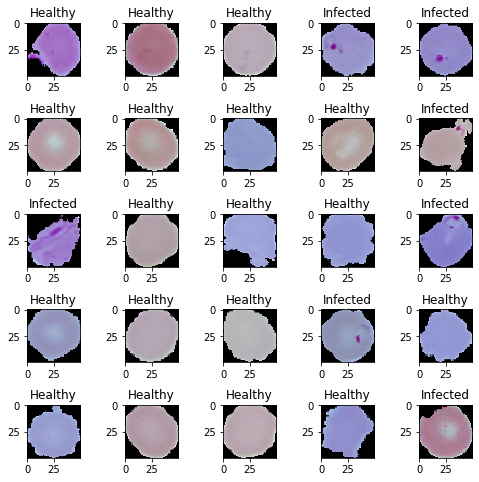

In [7]:
# plot the resized data

plt.figure(1 , figsize = (8 , 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.subplots_adjust(hspace = 0.8 , wspace = 0.8)
    random_number = random.choice(range(27558))
    plt.imshow(cell_data[random_number]/255.)
    plt.title(cell_labels[random_number])

In [8]:
# scale the data with /255 so the value is between 0 and 1

cell_data /= 255.

# encode the labels to digits 0 and 1

le = LabelEncoder()
le.fit(cell_labels)

print(cell_labels[:6])
cell_labels = le.transform(cell_labels) 
print(cell_labels[:6])

['Infected' 'Infected' 'Healthy' 'Healthy' 'Healthy' 'Healthy']
[1 1 0 0 0 0]


In [9]:
# split the whole dataset in 6:3:1 for train, validatation and test datasets

# first separate the test datasets with 0.1 
train_data, val_data, train_labels, val_labels =\
train_test_split(cell_data,cell_labels, test_size=0.1, random_state=42)

# then separate the test datasets with 0.3
train_data, test_data, train_labels, test_labels =\
train_test_split(train_data,train_labels, test_size=1/3, random_state=42)

print('Train Shape', str(train_data.shape)+',', Counter(train_labels))
print('Validation Shape', str(val_data.shape)+',', Counter(val_labels))
print('Test Shape:', str(test_data.shape)+',', Counter(test_labels))

Train Shape (16534, 50, 50, 3), Counter({1: 8340, 0: 8194})
Validation Shape (2756, 50, 50, 3), Counter({0: 1383, 1: 1373})
Test Shape: (8268, 50, 50, 3), Counter({0: 4202, 1: 4066})


## Build the neural network

In [10]:
# define model architecture

inp = tf.keras.layers.Input(shape=(50, 50, 3))

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
drop1 = tf.keras.layers.Dropout(rate=0.3)(pool2)
conv3 = tf.keras.layers.Conv2D(8, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop1)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool2)

hidden1 = tf.keras.layers.Dense(256, activation='relu')(flat)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden1)

hidden2 = tf.keras.layers.Dense(32, activation='relu')(drop2)

out = tf.keras.layers.Dense(2, activation='softmax')(hidden2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

W1001 17:06:57.146282  3460 deprecation.py:506] From C:\Users\hien\Anaconda3\envs\ml_pr\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080

## Train neural network

In [12]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=2, min_lr=0.000001)

history = model.fit(x=train_data, y=train_labels, 
                    batch_size=64,
                    epochs=20, 
                    validation_data=(val_data, val_labels), 
                    verbose=1)

Train on 16534 samples, validate on 2756 samples
Epoch 1/20
16534/16534 [==============================] - 35s 2ms/sample - loss: 0.1798 - acc: 0.9377 - val_loss: 0.1606 - val_acc: 0.9503
Epoch 2/20
16534/16534 [==============================] - 32s 2ms/sample - loss: 0.1556 - acc: 0.9466 - val_loss: 0.1570 - val_acc: 0.9528
Epoch 3/20
16534/16534 [==============================] - 36s 2ms/sample - loss: 0.1348 - acc: 0.9538 - val_loss: 0.1436 - val_acc: 0.9565
Epoch 4/20
16534/16534 [==============================] - 34s 2ms/sample - loss: 0.1207 - acc: 0.9583 - val_loss: 0.1390 - val_acc: 0.9586
Epoch 5/20
16534/16534 [==============================] - 34s 2ms/sample - loss: 0.1014 - acc: 0.9646 - val_loss: 0.1503 - val_acc: 0.9554
Epoch 6/20
16534/16534 [==============================] - 36s 2ms/sample - loss: 0.0854 - acc: 0.9707 - val_loss: 0.1614 - val_acc: 0.9532
Epoch 7/20
16534/16534 [==============================] - 36s 2ms/sample - loss: 0.0688 - acc: 0.9764 - val_loss: 0.1

## Calculate Test Accuracy

In [13]:
test_accuracy = model.evaluate(x = test_data, y=test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', test_accuracy[1])

8268/8268 [==============================] - 8s 1ms/sample - loss: 0.3967 - acc: 0.9446

 Test_Accuracy:- 0.9446057


## Results

In [15]:
# get predictions as probabilities

test_predictions = model.predict(test_data)
print(test_predictions[:4])

[[9.9992239e-01 7.7574936e-05]
 [9.9930584e-01 6.9413142e-04]
 [9.9999714e-01 2.9157115e-06]
 [2.4805560e-09 1.0000000e+00]]


In [16]:
# get predicted classes

np.argmax(test_predictions, axis=1)[0:100]

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0], dtype=int64)

In [18]:
# get label classes

test_labels[0:100]

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0])

In [19]:
# plot confusion matrix

confusion = confusion_matrix(test_labels, np.argmax(test_predictions, axis=1))
print(confusion)

[[4056  146]
 [ 312 3754]]


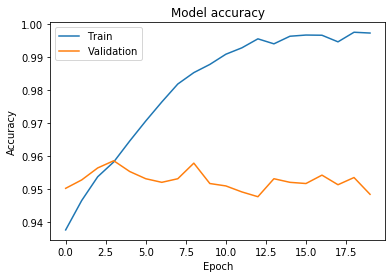

In [20]:
# plot training and validation accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

W1001 17:29:59.481536  3460 legend.py:1282] No handles with labels found to put in legend.


AUC:  0.9778416070580308


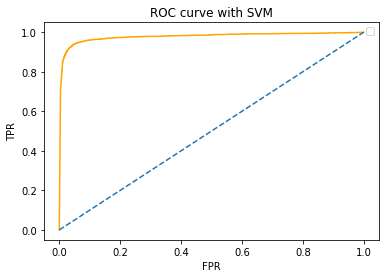

In [27]:
y_proba = test_predictions[:, 1]

# get fpr and tpr
fpr, tpr, thresholds = roc_curve(test_labels, y_proba, pos_label=1)

# plot ROC curve
plt.plot(fpr,tpr,color ='orange')
plt.legend(loc='best')
plt.plot([0,1], [0,1],ls='--')
plt.title('ROC curve with SVM')
plt.ylabel('TPR')
plt.xlabel('FPR');

# calculate AUC
print("AUC: ", auc(fpr, tpr))